In [ ]:
!pip install einops

In [ ]:
import matplotlib.pyplot as plt
import torch as t
import torch
import einops

In [ ]:
"""
display img with dimensions figsize
img is a np.array or tensor of shape [1, 3, H, W] or [3, H, W]
"""
def imshow(img, figsize=(6,6)):
    plt.figure(figsize=figsize)
    if len(img.shape) == 4: img = img.squeeze(0)
    if img.size(2) != 3: img = einops.rearrange(img, 'c h w -> h w c', c = 3)
    plt.axis("off")
    plt.imshow(img.detach())


In [ ]:
import torchvision 
model = torchvision.models.resnet34(pretrained=True)
model.eval();

# Image parameterization 1

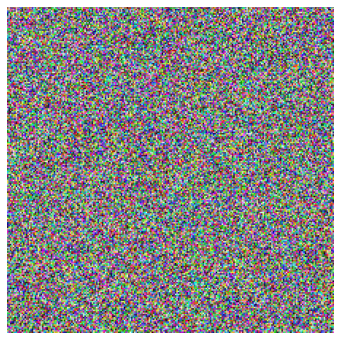

In [ ]:
from torch.nn import Module, Parameter

class Img(Module):
    def __init__(self, C = 3, H=224, W=224):
        super().__init__()
        self.img = Parameter(t.rand(1, C, H, W))

    def forward(self):
        return t.clip(self.img, min=0., max=1.)
        
imshow(Img()(),figsize=(6,6))

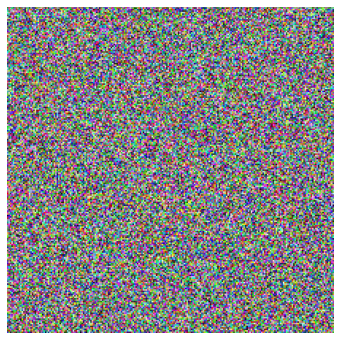

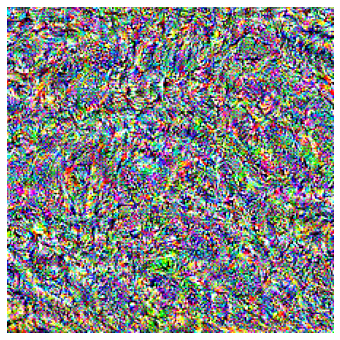

In [ ]:
# optimize input img to maximally activate logit n of model
def superstimulate(img, model, n, steps=50):
    device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
    img.to(device)
    img.train()
    model.to(device)
    model.eval()

    optimizer = t.optim.Adam(img.parameters(), lr=0.05, maximize=True)
    for _ in range(steps):
        optimizer.zero_grad()
        activation = model(img())[0,n]
        activation.backward()
        optimizer.step()

img = Img()
imshow(img())
superstimulate(img, model, 50, steps=50)
imshow(img().cpu(), figsize=(6,6))

# Image parameterization 2

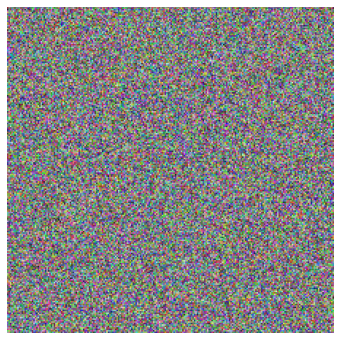

In [ ]:
from torch.nn import Module, Parameter

class Img(Module):
    def __init__(self, C = 3, H=224, W=224):
        super().__init__()
        self.img = Parameter(t.randn(1, C, H, W))

    def forward(self):
        return self.img.sigmoid()
        
imshow(Img()(),figsize=(6,6))

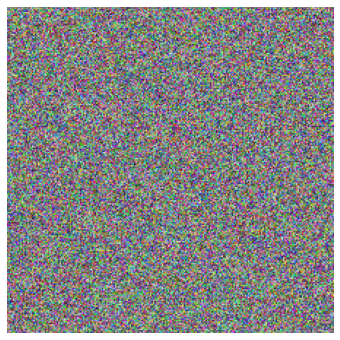

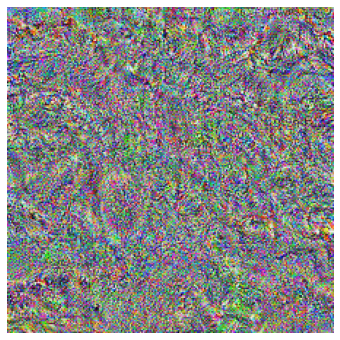

In [ ]:
# superstimulate same as in part 1

img = Img()
imshow(img())
superstimulate(img, model, 50, steps=100)
imshow(img().cpu())

# Transformation robustness

In [ ]:
import torchvision.transforms as transforms

perturb = transforms.Compose([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.05))
])

# optimize input img to maximally activate logit n of model
def superstimulate(img, model, n, lr=0.05, steps=50, pert=True):
    device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
    img.to(device)
    img.train()
    model.to(device)
    model.eval()
    
    optimizer = t.optim.Adam(img.parameters(), lr=lr, maximize=True)
    for _ in range(steps):
        optimizer.zero_grad()
        if pert:
            activation = model(perturb(img()))[0,n]
        else:
            activation = model(img())[0,n]
        activation.backward()
        optimizer.step()

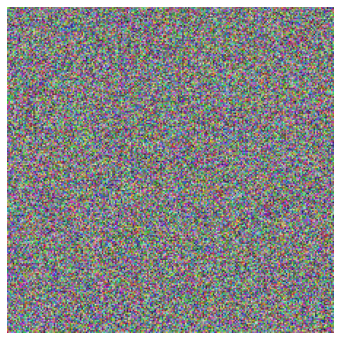

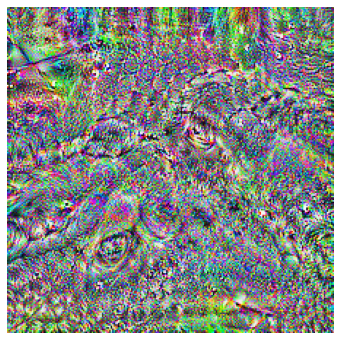

In [ ]:
img = Img()
imshow(img())
superstimulate(img, model, 50, steps=500)
imshow(img().cpu())

# Image parameterization 3

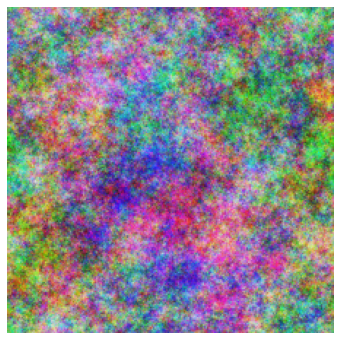

In [ ]:
from torch.nn import Module, Parameter

class Img(Module):
    def __init__(self, scale=0.1, C = 3, H=224, W=224):
        super().__init__()
        self.scale = scale
        self.freq_coeffs = Parameter(t.randn(1, C, H, W//2+1, 2))
        fh, fw =  t.meshgrid(t.fft.fftfreq(H), t.fft.fftfreq(W)[:W//2 + 1], indexing='ij')
        freqs = (fh**2 + fw**2).sqrt()
        freqs[0,0] = 1/H
        self.register_buffer('freqs', freqs)

    def forward(self):
        pixels = t.fft.irfft2(t.view_as_complex(self.freq_coeffs) / self.freqs, norm="ortho")
        return (pixels * self.scale).sigmoid()
        
imshow(Img()(),figsize=(6,6))

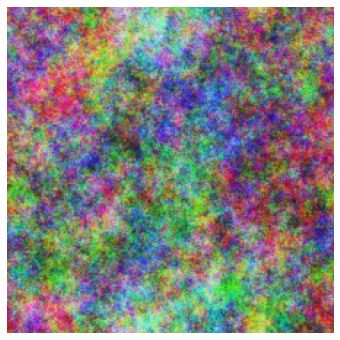

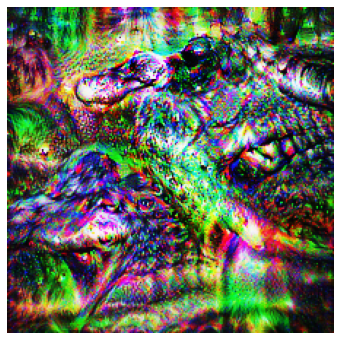

In [ ]:
img = Img()
imshow(img())
superstimulate(img, model, 50, lr=0.1, steps=500)
imshow(img().cpu())

# Image parameterization 4

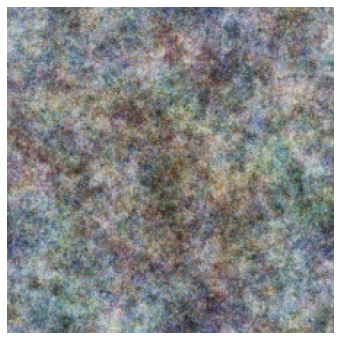

In [83]:
from torch.nn import Module, Parameter

# change of basis matrix from decorrelated basis to RGB basis
ChoB = t.Tensor(
    [[ 0.56282854,  0.19482528,  0.0432945],
     [ 0.5844758,   0.,         -0.10823626],
     [ 0.5844758,  -0.19482528,  0.06494176]]
)

class Img(Module):
    def __init__(self, scale = .1, C = 3, H=224, W=224):
        super().__init__()
        self.scale = scale
        self.freq_coeffs = Parameter(t.randn(1, C, H, W//2+1, 2))
        fh, fw =  t.meshgrid(t.fft.fftfreq(H), t.fft.fftfreq(W)[:W//2 + 1], indexing='ij')
        freqs = (fh**2 + fw**2).sqrt()
        freqs[0,0] = 1/H
        self.register_buffer('freqs', freqs)
        self.register_buffer('ChoB', ChoB)

    def forward(self):
        pixels = t.fft.irfft2(t.view_as_complex(self.freq_coeffs) / self.freqs, norm="ortho") * self.scale
        return t.einsum('ij, BjHW -> BiHW', self.ChoB, pixels).sigmoid()
        
imshow(Img(scale=.1)(),figsize=(6,6))

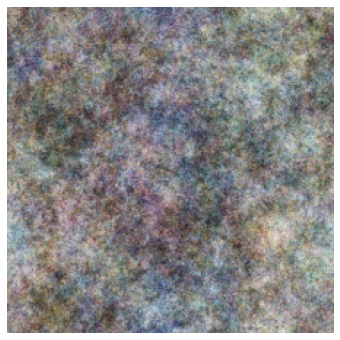

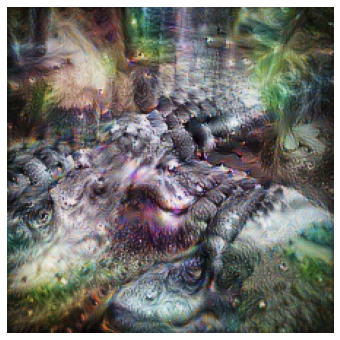

In [ ]:
img = Img(scale=.1)
imshow(img())
superstimulate(img, model, 50, lr=0.05, steps=500)
imshow(img().cpu())

# Comparing parameterizations

In [ ]:
# plot activations for feature n 
def plot_activations(n=50, lr=0.05, steps=200):
    img = Img()
    activations = []
    activations.append(model(img())[0,n])
    for _ in range(steps//10):
        superstimulate(img, model, n, lr=lr, steps=10)
        activations.append(model(img())[0,n])
    plt.plot(range(0,steps+1,10), t.Tensor(activations).detach())


You have to scroll up and run the implementation of Img corresponding to your desired paramterization before running plot_activations below, because that's a totally reasonable way to do this.

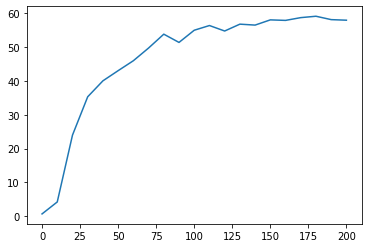

In [ ]:
# Parameterization 1
plot_activations()

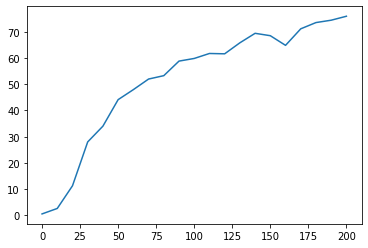

In [ ]:
# Parameterization 2
plot_activations()

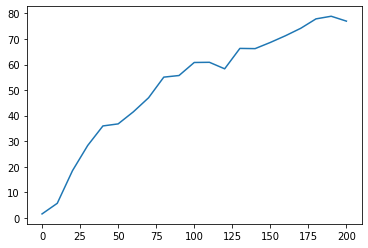

In [ ]:
# Parameterization 3 (with scale=0.1)
plot_activations()


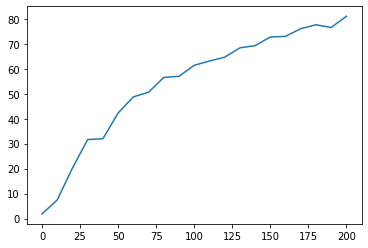

In [ ]:
# Parameterization 4 (with scale=0.1)
plot_activations()

# One big run with lots of training steps

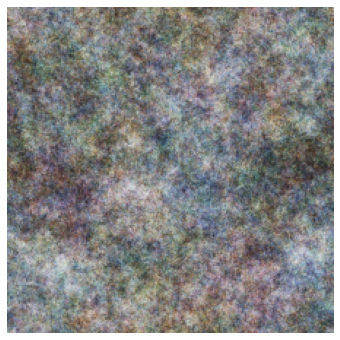

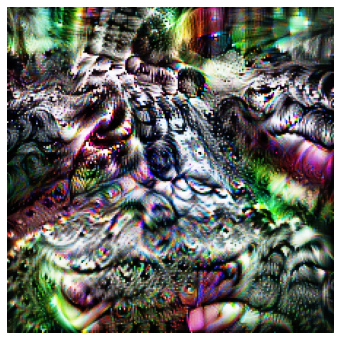

In [ ]:
img = Img(scale=.1)
imshow(img())
superstimulate(img, model, 50, lr=0.05, steps=10000)
imshow(img().cpu())

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/mlab/days/w1d5

/content/gdrive/MyDrive/mlab/days/w1d5


In [ ]:
import numpy
image = img().cpu()
image = image.squeeze(0)
image = einops.rearrange(image, 'c h w -> h w c', c=3)
plt.imsave('feature-vis-3.png', image.detach().numpy())

# Inner neuron feature visualization

In [130]:
class Hook:
  def __init__(self):
    self.out = None

  def __call__(self, module, module_inputs, module_outputs):
    self.out = module_outputs

def inner_neuron_superstimulate(img, model, layer, channel, lr=0.05, steps=50, pert=True):
  # move everything to the right device
  device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
  img.to(device)
  img.train()
  model.to(device)
  model.eval()
  
  # attach forward hooks to ReLU layers
  activations = []
  for m in model.modules():
    if isinstance(m, t.nn.ReLU):
      hook = Hook()
      activations.append(hook)
      m.register_forward_hook(hook)

  # superstimulate the neuron for the corresponding layer and channel
  optimizer = t.optim.Adam(img.parameters(), lr=lr, maximize=True)
  for _ in range(steps):
    optimizer.zero_grad()
    if pert: image = perturb(img())
    else: image = img()
    model(image)
    act = (activations[layer].out[0, channel] ** 2).sum()
    act.backward()
    optimizer.step() 

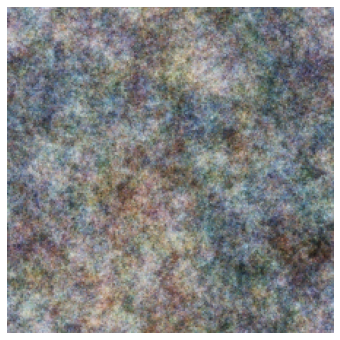

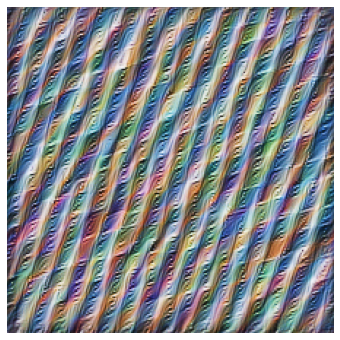

In [ ]:
img = Img()
imshow(img().cpu())
inner_neuron_superstimulate(img, model, 4, 4, steps=500)
imshow(img().cpu())

# Matching reference image activations

In [134]:
def match_inner_activations(img, target_img, model, layer, lr=0.05, steps=50):
  # move everything to the right device
  device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
  img.to(device)
  img.train()
  target_img = target_img.to(device)
  model.to(device)
  model.eval()
  
  # attach forward hooks to ReLU layers
  activations = []
  for m in model.modules():
    if isinstance(m, t.nn.ReLU):
      hook = Hook()
      activations.append(hook)
      m.register_forward_hook(hook)

  with t.no_grad(): model(target_img)
  target_activations = t.clone(activations[layer].out)

  optimizer = t.optim.Adam(img.parameters(), lr=lr)
  loss = t.nn.MSELoss()
  for _ in range(steps):
    optimizer.zero_grad()
    model(img())
    loss(activations[layer].out, target_activations).backward()
    optimizer.step()

In [139]:
from PIL import Image
from torchvision import transforms

target_img = transforms.ToTensor()(Image.open('fish_224x224.jpg')).unsqueeze(0)


imshow(target_img)
for layer in range(17):
  img = Img()
  match_inner_activations(img, target_img, model, layer, steps=1000)
  imshow(img().cpu())

Output hidden; open in https://colab.research.google.com to view.

In [140]:
target_img = transforms.ToTensor()(Image.open('flower_girl_224x224.jpg')).unsqueeze(0)


imshow(target_img)
for layer in range(17):
  img = Img()
  match_inner_activations(img, target_img, model, layer, steps=1000)
  imshow(img().cpu())

Output hidden; open in https://colab.research.google.com to view.